In [23]:
# -*- coding: utf-8 -*-
import os
import copy
import time
import json
import torch
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss

from IPython.core.display import HTML
from plotly.subplots import make_subplots

warnings.filterwarnings("ignore")  # avoid printing out absolute paths
import plotly.graph_objects as go


In [24]:
data = pd.read_csv('../Dataset/dariy_data/cow_weight_data.csv')
data

,time,체중(kg),index,개체번호,일일 착유 횟수,착유량(L),섭취량(kg),CO2 측정값,온도 측정값,습도 측정값,time_idx,농장아이디,출생일자,age,year_age,WOD
0,2020-01-21,675.0,1.0,20141014010030,2.0,78.0,7.0,0.0,0.0,0.0,1,20278,2014-10-14,1925,5-3-10-,4
1,2020-01-22,688.0,2.0,20141014010030,2.0,96.0,7.0,0.0,0.0,0.0,2,20278,2014-10-14,1926,5-3-11-,4
2,2020-01-23,701.0,3.0,20141014010030,2.0,90.0,7.0,0.0,0.0,0.0,3,20278,2014-10-14,1927,5-3-12-,4
3,2020-01-24,694.0,4.0,20141014010030,2.0,94.0,6.0,0.0,0.0,0.0,4,20278,2014-10-14,1928,5-3-13-,4
4,2020-01-25,693.0,5.0,20141014010030,2.0,94.0,6.0,0.0,0.0,0.0,5,20278,2014-10-14,1929,5-3-14-,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6645,2020-09-14,707.0,238.0,20140930010029,1.0,22.0,2.0,0.0,0.0,0.0,238,20278,2014-09-30,2176,5-11-21-,38
6646,2020-09-15,707.0,239.0,20140930010029,1.0,21.0,2.0,0.0,0.0,0.0,239,20278,2014-09-30,2177,5-11-22-,38
6647,2020-09-16,725.0,240.0,20140930010029,1.0,20.0,0.0,0.0,0.0,0.0,240,20278,2014-09-30,2178,5-11-23-,38
6648,2020-09-17,719.0,241.0,20140930010029,1.0,18.0,0.0,0.0,0.0,0.0,241,20278,2014-09-30,2179,5-11-24-,38


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      6650 non-null   object 
 1   체중(kg)    6650 non-null   float64
 2   index     6650 non-null   float64
 3   개체번호      6650 non-null   int64  
 4   일일 착유 횟수  6650 non-null   float64
 5   착유량(L)    6650 non-null   float64
 6   섭취량(kg)   6650 non-null   float64
 7   CO2 측정값   6650 non-null   float64
 8   온도 측정값    6650 non-null   float64
 9   습도 측정값    6650 non-null   float64
 10  time_idx  6650 non-null   int64  
 11  농장아이디     6650 non-null   int64  
 12  출생일자      6650 non-null   object 
 13  age       6650 non-null   int64  
 14  year_age  6650 non-null   object 
 15  WOD       6650 non-null   int64  
dtypes: float64(8), int64(5), object(3)
memory usage: 831.4+ KB


In [26]:
data.columns

Index(['time', '체중(kg)', 'index', '개체번호', '일일 착유 횟수', '착유량(L)', '섭취량(kg)',
       'CO2 측정값', '온도 측정값', '습도 측정값', 'time_idx', '농장아이디', '출생일자', 'age',
       'year_age', 'WOD'],
      dtype='object')

In [27]:
data['time_idx'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [28]:
data = data[data['time_idx'] < 240]
data

,time,체중(kg),index,개체번호,일일 착유 횟수,착유량(L),섭취량(kg),CO2 측정값,온도 측정값,습도 측정값,time_idx,농장아이디,출생일자,age,year_age,WOD
0,2020-01-21,675.0,1.0,20141014010030,2.0,78.0,7.0,0.0,0.0,0.0,1,20278,2014-10-14,1925,5-3-10-,4
1,2020-01-22,688.0,2.0,20141014010030,2.0,96.0,7.0,0.0,0.0,0.0,2,20278,2014-10-14,1926,5-3-11-,4
2,2020-01-23,701.0,3.0,20141014010030,2.0,90.0,7.0,0.0,0.0,0.0,3,20278,2014-10-14,1927,5-3-12-,4
3,2020-01-24,694.0,4.0,20141014010030,2.0,94.0,6.0,0.0,0.0,0.0,4,20278,2014-10-14,1928,5-3-13-,4
4,2020-01-25,693.0,5.0,20141014010030,2.0,94.0,6.0,0.0,0.0,0.0,5,20278,2014-10-14,1929,5-3-14-,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6642,2020-09-11,713.0,235.0,20140930010029,1.0,22.0,2.0,0.0,0.0,0.0,235,20278,2014-09-30,2173,5-11-18-,37
6643,2020-09-12,712.0,236.0,20140930010029,1.0,20.0,2.0,0.0,0.0,0.0,236,20278,2014-09-30,2174,5-11-19-,37
6644,2020-09-13,720.0,237.0,20140930010029,1.0,21.0,2.0,0.0,0.0,0.0,237,20278,2014-09-30,2175,5-11-20-,37
6645,2020-09-14,707.0,238.0,20140930010029,1.0,22.0,2.0,0.0,0.0,0.0,238,20278,2014-09-30,2176,5-11-21-,38


In [29]:
max_prediction_length = 7
max_encoder_length = 30


training_cutoff = data["time_idx"].max() - (max_prediction_length + max_encoder_length) 

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="체중(kg)",
    group_ids=["개체번호"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],
    time_varying_known_reals=['WOD'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['일일 착유 횟수' , '착유량(L)' , '섭취량(kg)', 'CO2 측정값' , '온도 측정값' , 'age'],
    target_normalizer=GroupNormalizer(
        groups=["개체번호"], transformation=None
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    #allow_missing_timesteps=True
)


In [30]:
validation = TimeSeriesDataSet.from_dataset(training, data[data['time_idx'] > training_cutoff] , predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 256  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-6, patience=10, verbose=False, mode="min")
logger = TensorBoardLogger(f"lightning_logs/init_test")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[early_stop_callback],
    logger=logger,
    devices = [0]
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-4,
    hidden_size=32,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=32,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [31]:
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 704   
4  | static_variable_selection          | VariableSelectionNetwork        | 13.4 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 37.4 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 8.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lst

Number of parameters in network: 112.6k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [82]:
raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True , return_y=True ,  trainer_kwargs=dict(accelerator="cpu"))

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


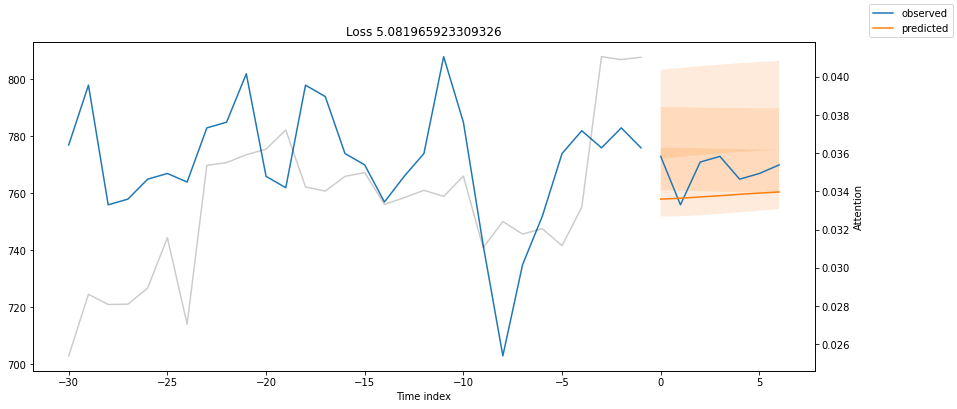

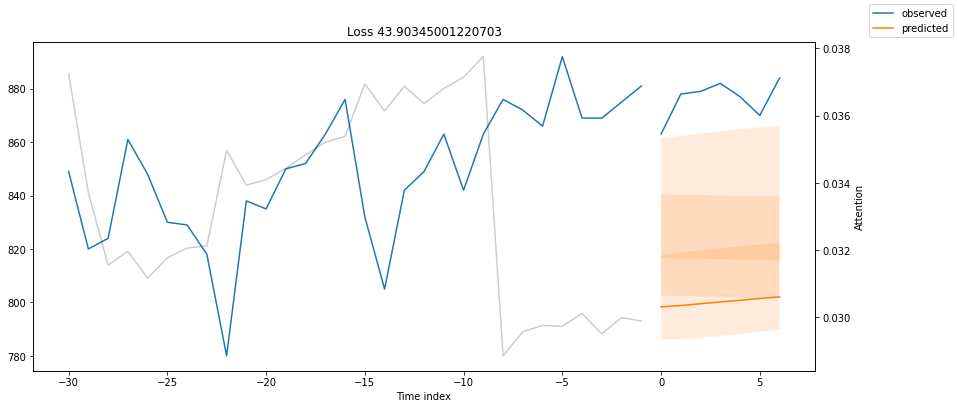

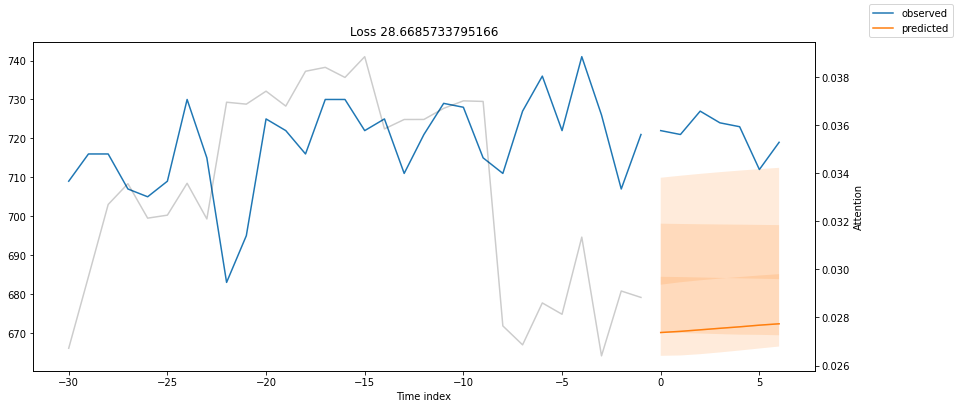

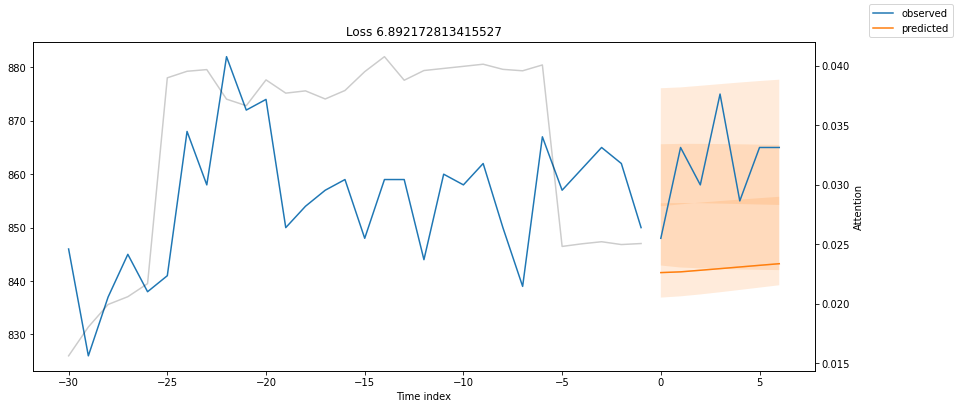

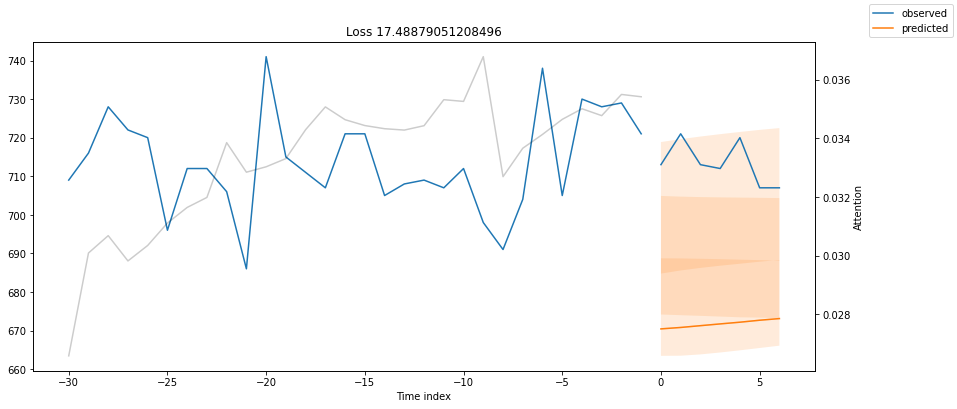

In [102]:
for idx in range(25):  # plot 10 examples
    fig = tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    fig.set_size_inches(14, 6)
    fig.savefig(f'test{idx}.png')
    if idx > 3:
        break

In [97]:
predictions = tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(44.4961)